# Assignment overview <ignore>
The overarching goal of this assignment is to produce a research report in which you implement, analyse, and discuss various Neural Network techniques. You will be guided through the process of producing this report, which will provide you with experience in report writing that will be useful in any research project you might be involved in later in life.

All of your report, including code and Markdown/text, ***must*** be written up in ***this*** notebook. This is not typical for research, but is solely for the purpose of this assignment. Please make sure you change the title of this file so that XXXXXX is replaced by your candidate number. You can use code cells to write code to implement, train, test, and analyse your NNs, as well as to generate figures to plot data and the results of your experiments. You can use Markdown/text cells to describe and discuss the modelling choices you make, the methods you use, and the experiments you conduct. So that we can mark your reports with greater consistency, please ***do not***:

* rearrange the sequence of cells in this notebook.
* delete any cells, including the ones explaining what you need to do.

If you want to add more code cells, for example to help organise the figures you want to show, then please add them directly after the code cells that have already been provided. 

Please provide verbose comments throughout your code so that it is easy for us to interpret what you are attempting to achieve with your code. Long comments are useful at the beginning of a block of code. Short comments, e.g. to explain the purpose of a new variable, or one of several steps in some analyses, are useful on every few lines of code, if not on every line. Please do not use the code cells for writing extensive sentences/paragraphs that should instead be in the Markdown/text cells.

# Abstract/Introduction (instructions) - 15 MARKS <ignore>
Use the next Markdown/text cell to write a short introduction to your report. This should include:
* a brief description of the topic (image classification) and of the dataset being used (CIFAR10 dataset). (2 MARKS)
* a brief description of how the CIFAR10 dataset has aided the development of neural network techniques, with examples. (3 MARKS)
* a descriptive overview of what the goal of your report is, including what you investigated. (5 MARKS)
* a summary of your major findings. (3 MARKS)
* two or more relevant references. (2 MARKS)

*Enter your abstract/introduction here*

# Methodology (instructions) - 55 MARKS <ignore>
Use the next cells in this Methodology section to describe and demonstrate the details of what you did, in practice, for your research. Cite at least two academic papers that support your model choices. The overarching prinicple of writing the Methodology is to ***provide sufficient details for someone to replicate your model and to reproduce your results, without having to resort to your code***. You must include at least these components in the Methodology:
* Data - Decribe the dataset, including how it is divided into training, validation, and test sets. Describe any pre-processing you perform on the data, and explain any advantages or disadvantages to your choice of pre-processing. 
* Architecture - Describe the architecture of your model, including all relevant hyperparameters. The architecture must include 3 convolutional layers followed by two fully connected layers. Include a figure with labels to illustrate the architecture.
* Loss function - Describe the loss function(s) you are using, and explain any advantages or disadvantages there are with respect to the classification task.
* Optimiser - Describe the optimiser(s) you are using, including its hyperparameters, and explain any advantages or disadvantages there are to using that optimser.
* Experiments - Describe how you conducted each experiment, including any changes made to the baseline model that has already been described in the other Methodology sections. Explain the methods used for training the model and for assessing its performance on validation/test data.


## Data (7 MARKS) <ignore>

*Describe the dataset and any pre-processing here*

## Architecture (17 MARKS) <ignore>

*Describe the architecture here*

## Loss function (3 MARKS) <ignore>

*Describe the loss function here*

## Optimser (4 MARKS) <ignore>

*Describe the optimiser here*

## Experiments <ignore>
### Experiment 1 (8 MARKS)

*Describe how you went about conducting experiment 1 here*

### Experiment 2 (8 MARKS) <ignore>

*Describe how you went about conducting experiment 2 here*

### Experiment 3 (8 MARKS) <ignore>

*Describe how you went about conducting experiment 3 here*

In [9]:
############################################
### Code for building the baseline model ###
############################################

# Commands for setting up the environment
  # conda create -n nn_env python=3.8
  # conda activate nn_env
  # pip3 install torch==2.3.0+cu121 torchvision==0.18+cu121 matplotlib -f https://download.pytorch.org/whl/cu121/torch_stable.html
  # conda install ipykernel
  # python -m ipykernel install --user --name=nn_env --display-name="Neural Networks"
  # conda install jupyterlab
  # jupyter lab


# Imports

import torch
from   torch                  import nn
from   torch.utils.data       import DataLoader
from   torchvision            import datasets
from   torchvision.transforms import ToTensor

from   statistics             import mean

import matplotlib.pyplot      as plt
import numpy                  as np
import time, json, pickle


# Model class

class NeuralNetwork(nn.Module):

    def __init__(self, dropout_rate=0):

        super(NeuralNetwork, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d( 3,  32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            nn.Conv2d(32,  64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.full_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),

            nn.Dropout(dropout_rate),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        logits = self.full_layers(self.flatten(self.conv_layers(x)))
        return logits


# Function to train a model and test it periodically
# returns information about the losses and accuracies through the training process

def train_and_test(model, train_set, test_set, num_batches, loss_fn, optimizer, scheduler, num_epochs, device):
    
    assert len(train_set) % num_batches == 0
    assert len(test_set ) % num_batches == 0
    
    train_batch_size = len(train_set) // num_batches
    test_batch_size  = len(test_set)  // num_batches

    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    test_loader  = DataLoader(test_set , batch_size=test_batch_size , shuffle=True)
    
    train_losses = []
    test_losses  = []
    accuracies   = []

    smoothed_test_loss = 3
    
    for epoch in range(num_epochs):
    
        for train_batch, test_batch in zip(train_loader, test_loader):
            
            model.eval()
            X, y = test_batch
            X, y = X.to(device), y.to(device)
            
            with torch.no_grad():
                pred = model(X)
                loss = loss_fn(pred, y)
                test_loss = loss.item()
                test_losses.append(test_loss)
                num_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                accuracies.append(num_correct / test_batch_size)
            
            model.train()
            X, y = train_batch
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            train_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if scheduler:
                smoothed_test_loss *= 0.97
                smoothed_test_loss += test_loss*0.03
                scheduler.step(smoothed_test_loss)
        
        print(f'Epoch #{epoch+1:>3} done', end='\r', flush=True)
    print(' '*20, end='\r', flush=True)
    
    num_datapoints = num_batches * num_epochs
    
    return train_losses, test_losses, accuracies, num_epochs, num_batches, num_datapoints


# Exponential smoothing function for smooth lines in plots

def exp_smooth(nums, alpha=0.03):
    smoothed = [nums[0]]
    for i in range(1,len(nums)):
        smoothed.append(nums[i]*alpha + smoothed[-1]*(1-alpha))
    return smoothed
    

# Function to plot information returned by train_and_test()

def plot_metrics_to_axes(metrics, ax, ticks=(), labels=False, legend=False, show_unsmoothed=False, annotate=False, max_epochs=None):
    
    train_losses, test_losses, accuracies, num_epochs, num_batches, num_datapoints = metrics
    if max_epochs:
        num_epochs     = min(num_epochs, max_epochs)
        num_datapoints = num_epochs * num_batches
        train_losses   = train_losses[:num_datapoints]
        test_losses    = test_losses [:num_datapoints]
        accuracies     = accuracies  [:num_datapoints]
    general_gap = [a-b for (a,b) in zip(test_losses, train_losses)]
    
    smoothed_train_losses = exp_smooth(train_losses)
    smoothed_test_losses  = exp_smooth(test_losses)
    smoothed_general_gap  = exp_smooth(general_gap)
    smoothed_accuracies   = exp_smooth(accuracies)
    
    epochs = [v/num_batches for v in range(1, num_datapoints+1)]

    if show_unsmoothed:
        l1, = ax.plot(epochs, train_losses, color='tab:blue'  , alpha=0.15)
        l2, = ax.plot(epochs, test_losses , color='tab:green' , alpha=0.15)
        l3, = ax.plot(epochs, general_gap , color='tab:orange', alpha=0.15)
    
    l4, = ax.plot(epochs, smoothed_train_losses, color='tab:blue'  , label='Training loss')
    l5, = ax.plot(epochs, smoothed_test_losses , color='tab:green' , label='Testing loss')
    l6, = ax.plot(epochs, smoothed_general_gap , color='tab:orange', label='Generalization gap')
    
    ax.set_xlim((0,num_epochs))
    ax.set_ylim((0,3))
    ax.grid(True)
    
    ax2 = ax.twinx()
    l7, = ax2.plot(epochs, smoothed_accuracies  , color='tab:purple', label='Accuracy')
    ax2.set_ylim((0,1))

    if 'bottom' not in ticks: ax .set_xticklabels([])
    if 'left'   not in ticks: ax .set_yticklabels([])
    if 'right'  not in ticks: ax2.set_yticklabels([])

    if labels:
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy score')

    if annotate:
        x1,y1 = min(zip(smoothed_test_losses, epochs))[::-1]
        p1,   = ax .plot(x1, y1, 'o', markersize=10, mfc='none', mec='black', mew=2)
        x2,y2 = max(zip(smoothed_accuracies, epochs))[::-1]
        p2,   = ax2.plot(x2, y2, 'o', markersize=10, mfc='none', mec='gray' , mew=2)
        ax.legend([p1,p2],[f'({x1:>.1f},{y1:>.2f})', f'({x2:>.1f},{y2:>.2f})'])

    if legend:
        lines  = [l4, l5, l6, l7]
        labels = [line.get_label() for line in lines]
        ax.legend(lines, labels)



# Function to plot information returned by train_and_test() for immediate display

def plot_metrics(metrics):
    fig, ax = plt.subplots()
    plot_metrics_to_axes(metrics, ax, labels=True, legend=True,
                         show_unsmoothed=True, ticks=('left','bottom','right'),
                         annotate = True)
    plt.show()


# Function to calculate the means of lists recursively

def rec_mean(l):
    if all(isinstance(x,int) or isinstance(x,float) for x in l): return mean(l)
    else: return [rec_mean(x) for x in zip(*l)]


# Check available device for training

if   torch.cuda.is_available():         device='cuda'
elif torch.backends.mps.is_available(): device='mps'
else:                                   device='cpu'

# Set resolution for plots

plt.rcParams['figure.dpi'] = 90

print(f'Device: {device}')

Device: cuda


Files already downloaded and verified
Files already downloaded and verified


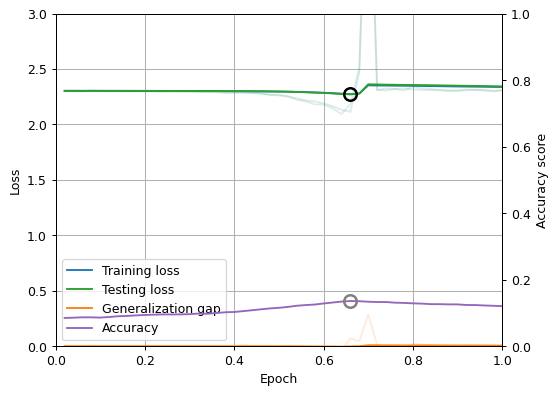

In [10]:
train_set = datasets.CIFAR10(root='data', train=True , download=True, transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor())

model     = NeuralNetwork(dropout_rate=0.2).to(device)
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = None

metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 1, device)

plot_metrics(metrics)

# Results (instructions) - 55 MARKS <ignore>
Use the Results section to summarise your findings from the experiments. For each experiment, use the Markdown/text cell to describe and explain your results, and use the code cell (and additional code cells if necessary) to conduct the experiment and produce figures to show your results.

### Experiment 1 (17 MARKS) <ignore>

*Write up results for Experiment 1 here*

In [3]:
#############################
### Code for Experiment 1 ###
#############################

In [38]:
with open('results.pickle','rb+') as f:
    results = pickle.load(f)

for learning_rate in [0.1**1.6]:
    print(f'Learning rate = {learning_rate}')
    for i in range(1, 6):
        print(f'Trial #{i}')
        model     = NeuralNetwork().to(device)
        loss_fn   = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        scheduler = None
        metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 120, device)
        results[learning_rate] = results.get(learning_rate,[]) + [metrics]

with open('results.pickle','wb+') as f:
    pickle.dump(results, f)

Learning rate = 0.025118864315095798
Trial #1
Trial #2            
Trial #3            
Trial #4            
Trial #5            


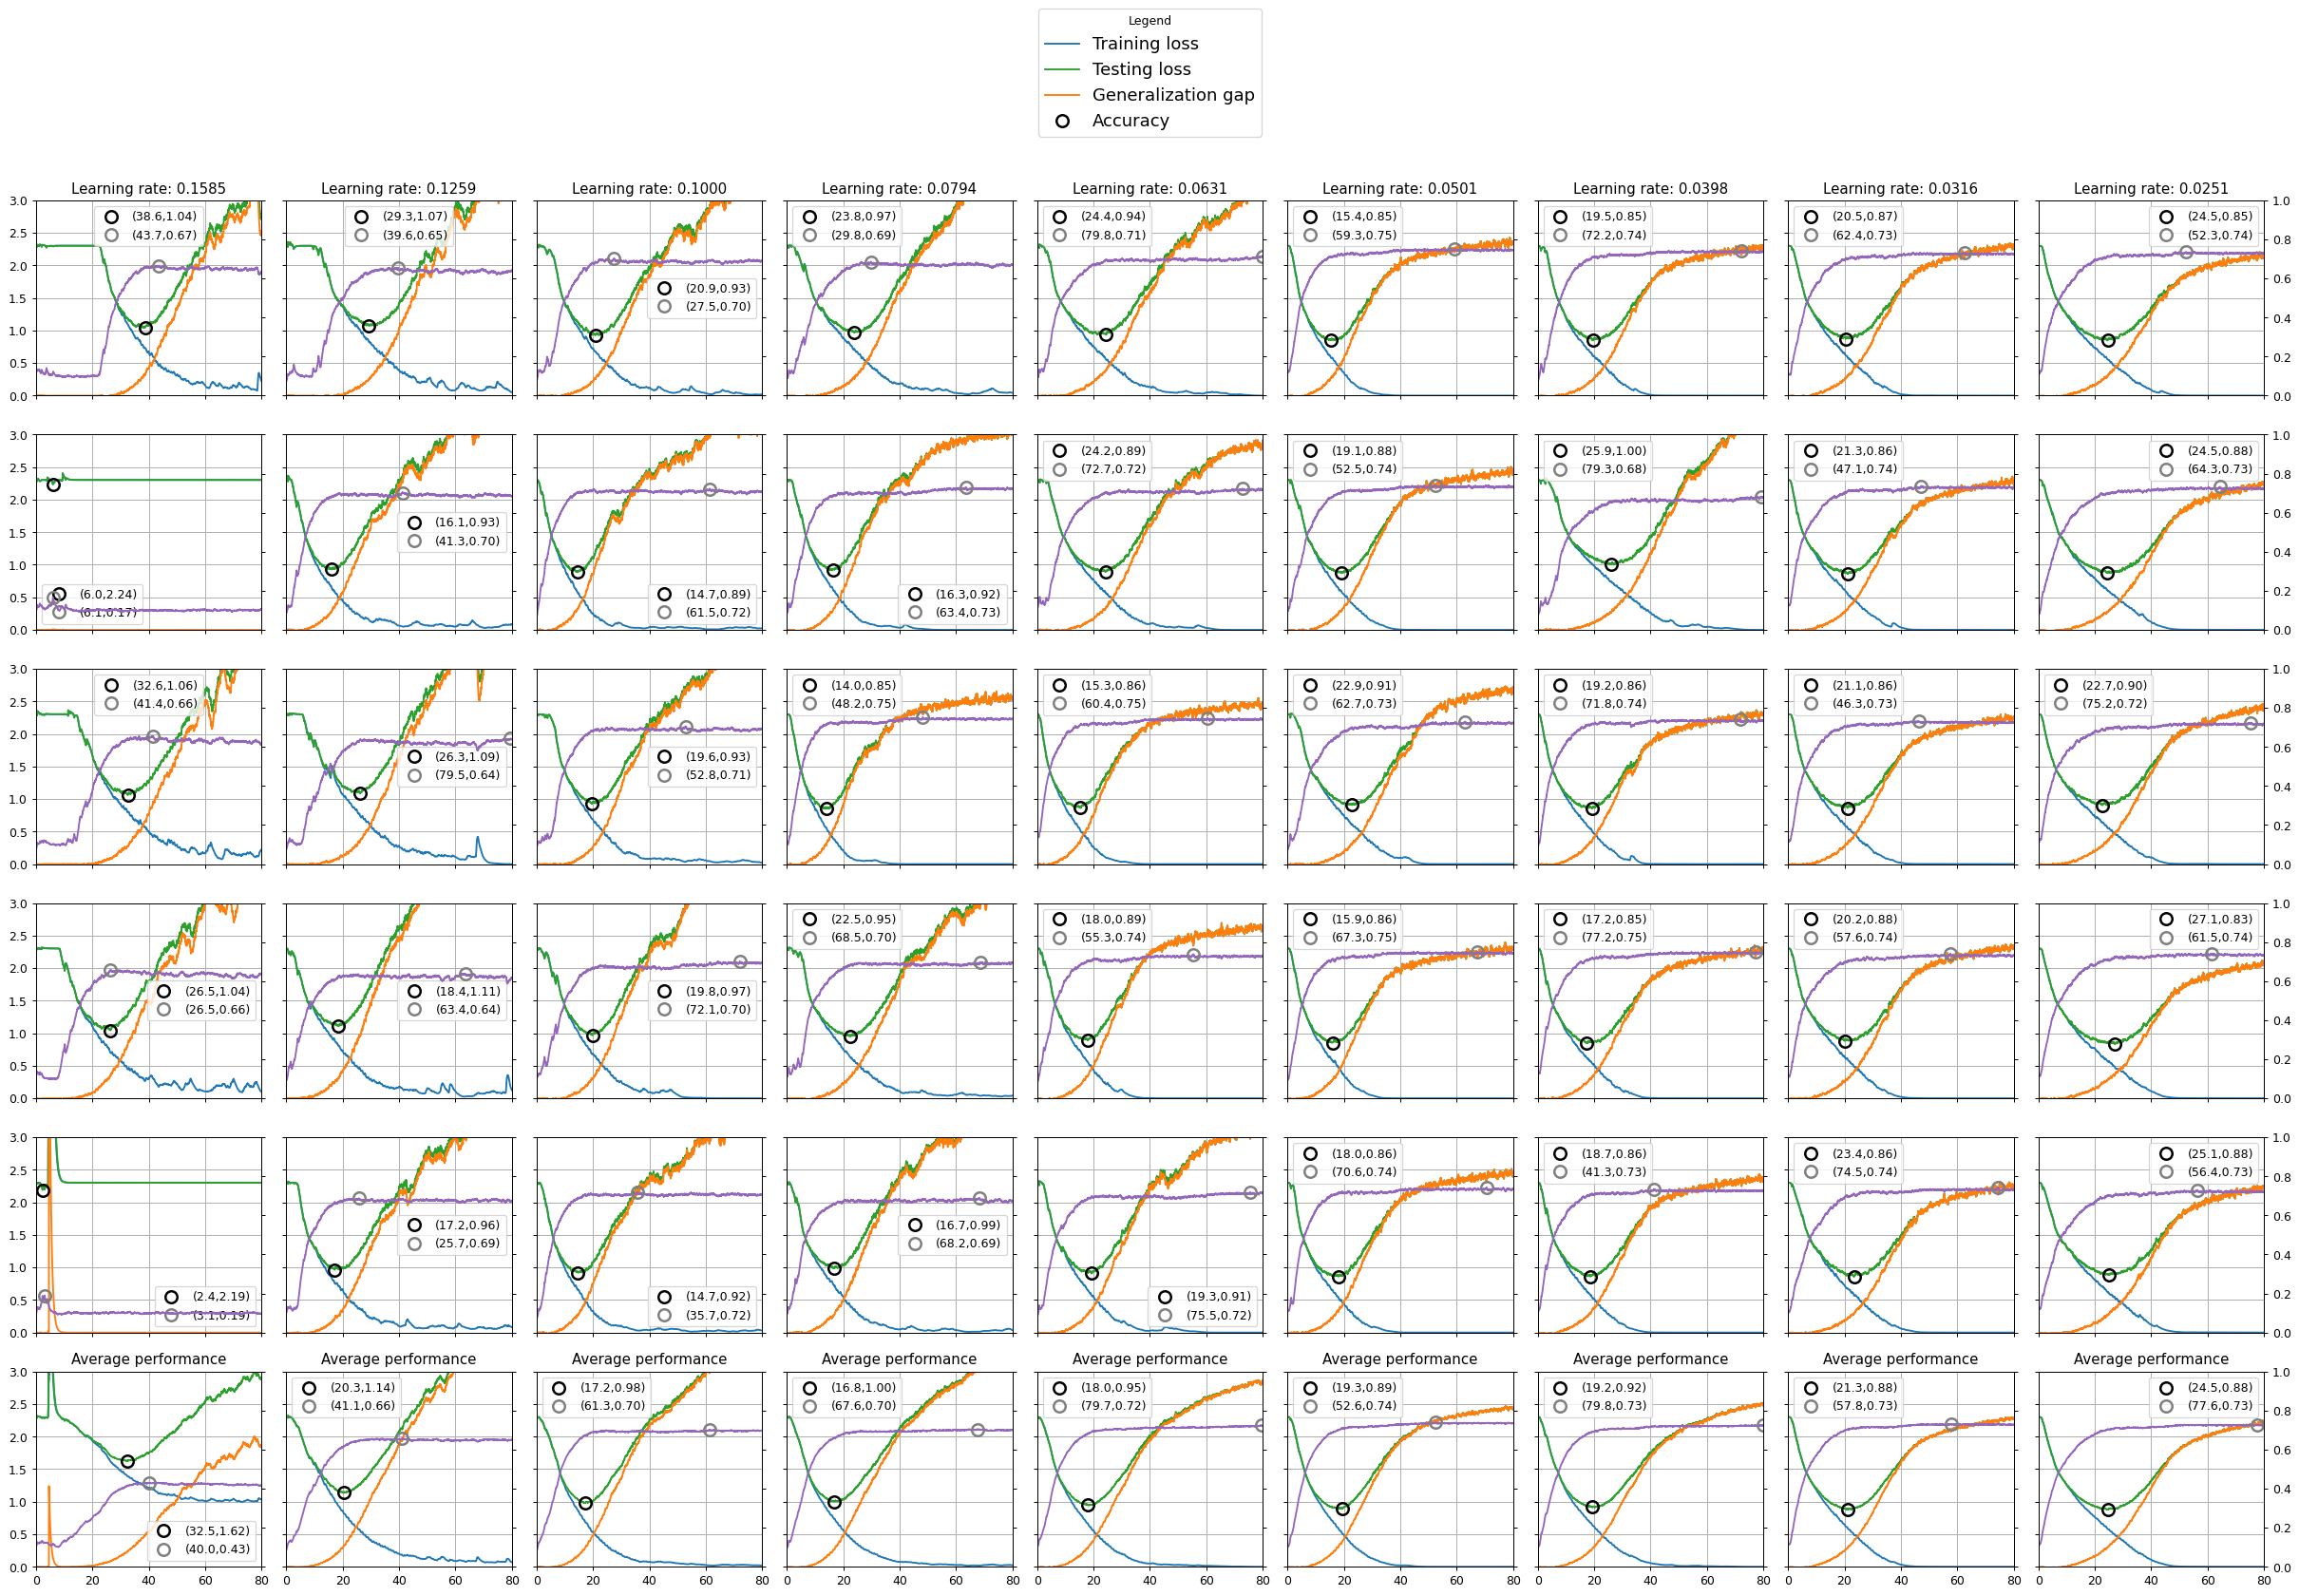

In [237]:
# Creating a 6x9 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=9, figsize=(27,18))

# Plotting data in each subplot
for col, lr in enumerate(results):
    performance_mean = rec_mean(results[lr])
    for row, data in enumerate(results[lr][:5]+[performance_mean]):
        ticks = ('bottom',)*(row==5) + ('left',)*(col==0) + ('right',)*(col==8)
        plot_metrics_to_axes(data, axes[row,col], ticks=ticks, annotate=True, max_epochs=80)
        if row == 0: axes[row,col].set_title(f'Learning rate: {lr:>.4f}')
        if row == 5: axes[row,col].set_title('Average performance')

# Creating a horizontally centered unified legend for the whole figure
fig.legend(['Training loss', 'Testing loss', 'Generalization gap', 'Accuracy'],
           loc='upper center', title='Legend', bbox_to_anchor=(0.5, 1.04), fontsize='x-large')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [263]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

with open('results.pickle','rb+') as f:
    results = pickle.load(f)

model     = NeuralNetwork().to(device)
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1**0.1, patience=10)
metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 30, device)
results['reduce_lr_on_plateau'] = metrics

with open('results.pickle','wb+') as f:
    pickle.dump(results, f)

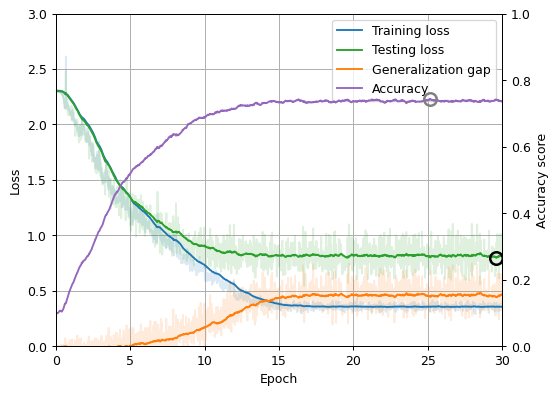

In [270]:
plot_metrics(results['reduce_lr_on_plateau'])

### Experiment 2 (19 MARKS) <ignore>

*Write up results for Experiment 2 here*

In [2]:
#############################
### Code for Experiment 2 ###
#############################

In [11]:
with open('results.pickle','rb+') as f:
    results = pickle.load(f)

results['dropout_rate'] = {}

dropout_models = {}

for dropout_rate in [0.0, 0.1, 0.2, 0.3, 0.4]:
    print(f'Dropout rate = {dropout_rate}')
    for i in range(1, 6):
        print(f'Trial #{i}')
        model     = NeuralNetwork(dropout_rate = dropout_rate).to(device)
        loss_fn   = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
        scheduler = None
        metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 120, device)
        results['dropout_rate'][dropout_rate] = results['dropout_rate'].get(dropout_rate,[]) + [metrics]
        dropout_models[dropout_rate] = model

with open('results.pickle','wb+') as f:
    pickle.dump(results, f)

Dropout rate = 0.0
Trial #1
Trial #2            
Trial #3            
Trial #4            
Trial #5            
Dropout rate = 0.1  
Trial #1
Trial #2            
Trial #3            
Trial #4            
Trial #5            
Dropout rate = 0.2  
Trial #1
Trial #2            
Trial #3            
Trial #4            
Trial #5            
Dropout rate = 0.3  
Trial #1
Trial #2            
Trial #3            
Trial #4            
Trial #5            
Dropout rate = 0.4  
Trial #1
Trial #2            
Trial #3            
Trial #4            
Trial #5            


In [ ]:
# Creating a 6x5 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15,18))

# Plotting data in each subplot
for col, dr in enumerate(results['dropout_rate']):
    performance_mean = rec_mean(results['dropout_rate'][dr])
    for row, data in enumerate(results['dropout_rate'][dr][:5]+[performance_mean]):
        ticks = ('bottom',)*(row==5) + ('left',)*(col==0) + ('right',)*(col==8)
        plot_metrics_to_axes(data, axes[row,col], ticks=ticks, annotate=True, max_epochs=80)
        if row == 0: axes[row,col].set_title(f'Dropout rate: {dr:>.4f}')
        if row == 5: axes[row,col].set_title('Average performance')

# Creating a horizontally centered unified legend for the whole figure
fig.legend(['Training loss', 'Testing loss', 'Generalization gap', 'Accuracy'],
           loc='upper center', title='Legend', bbox_to_anchor=(0.5, 1), fontsize='medium')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### Experiment 3 (19 MARKS) <ignore>

*Write up results for Experiment 3 here*

In [ ]:
#############################
### Code for Experiment 3 ###
#############################

# Conclusions and Discussion (instructions) - 25 MARKS <ignore>
In this section, you are expected to:
* briefly summarise and describe the conclusions from your experiments (8 MARKS).
* discuss whether or not your results are expected, providing scientific reasons (8 MARKS).
* discuss two or more alternative/additional methods that may enhance your model, with scientific reasons (4 MARKS). 
* Reference two or more relevant academic publications that support your discussion. (4 MARKS)

*Write your Conclusions/Discussion here*

# References (instructions) <ignore>
Use the cell below to add your references. A good format to use for references is like this:

[AB Name], [CD Name], [EF Name] ([year]), [Article title], [Journal/Conference Name] [volume], [page numbers] or [article number] or [doi]

Some examples:

JEM Bennett, A Phillipides, T Nowotny (2021), Learning with reinforcement prediction errors in a model of the Drosophila mushroom body, Nat. Comms 12:2569, doi: 10.1038/s41467-021-22592-4

SO Kaba, AK Mondal, Y Zhang, Y Bengio, S Ravanbakhsh (2023), Proc. 40th Int. Conf. Machine Learning, 15546-15566

*List your references here*